In [1]:
%matplotlib inline

from warnings import filterwarnings

from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

filterwarnings('ignore', message='findfont')

SEED = 3264602 # from random.org

np.random.seed(SEED)

In [2]:
N = 10000

μ_actual = np.array([1, -2])
Σ_actual = np.array([[0.5, -0.3],
                     [-0.3, 1.]])

x = np.random.multivariate_normal(μ_actual, Σ_actual, size=N)

var, U = np.linalg.eig(Σ_actual)
angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))

In [6]:
U

array([[-0.90558942,  0.4241554 ],
       [-0.4241554 , -0.90558942]])

In [16]:
from scipy import stats
mvn = stats.multivariate_normal(mean=μ_actual , cov=Σ_actual )


TypeError: pdf() missing 1 required positional argument: 'x'

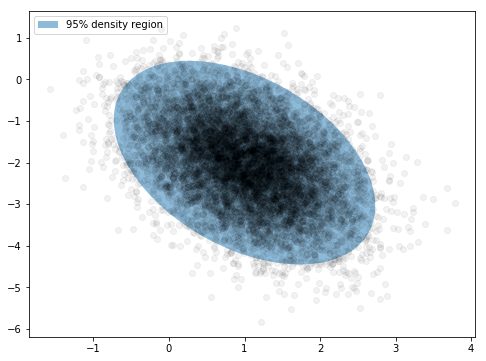

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red, *_ = sns.color_palette()

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]),
            2 * np.sqrt(5.991 * var[1]),
            angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10);
ax.add_artist(e);

ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.05, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect], ['95% density region'], loc=2);

In [3]:
with pm.Model() as model:
    packed_L = pm.LKJCholeskyCov('packed_L', n=2,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))

In [4]:
packed_L.tag.test_value.shape

(3,)

In [5]:
with model:
    L = pm.expand_packed_triangular(2, packed_L)
    Σ = pm.Deterministic('Σ', L.dot(L.T))

/Users/yuho.kida/python_DS/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/yuho.kida/python_DS/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [6]:
L.tag.test_value.shape

(2, 2)

In [7]:
with model:
    μ = pm.Normal('μ', 0., 10., shape=2,
                  testval=x.mean(axis=0))
    obs = pm.MvNormal('obs', μ, chol=L, observed=x)

In [8]:
with model:
    trace = pm.sample(random_seed=SEED, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/yuho.kida/python_DS/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/yuho.kida/python_DS/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/yuho.kida/python_DS/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensi

/Users/yuho.kida/python_DS/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/yuho.kida/python_DS/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/yuho.kida/python_DS/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


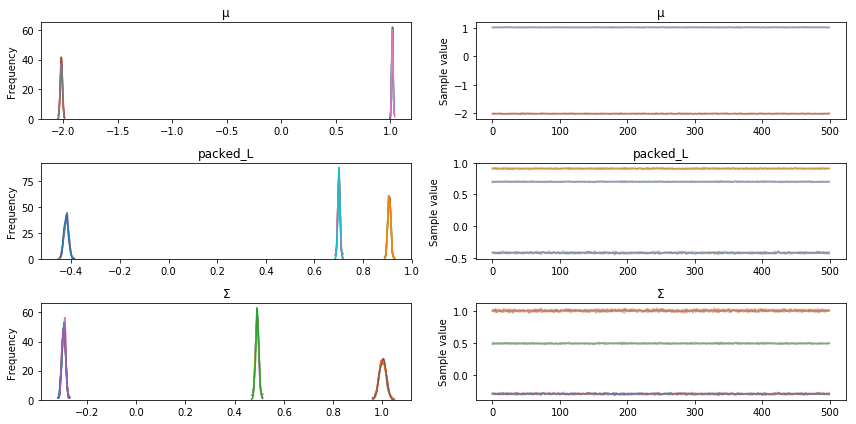

In [9]:
pm.traceplot(trace);

In [10]:
μ_post = trace['μ'].mean(axis=0)
1 - μ_post / μ_actual

array([-0.0183027 , -0.00937607])

In [11]:
Σ_post = trace['Σ'].mean(axis=0)
1 - Σ_post / Σ_actual

array([[ 0.0173913 ,  0.01695977],
       [ 0.01695977, -0.00174649]])

In [12]:
Σ_post

array([[ 0.49130435, -0.29491207],
       [-0.29491207,  1.00174649]])

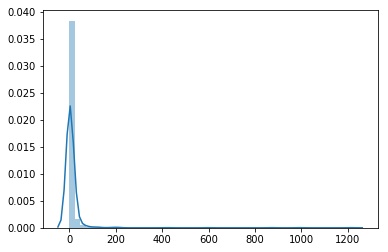

In [89]:
sd_dist=pm.HalfCauchy.dist(2.5)
sns.distplot(sd_dist.random(size=1000))

In [90]:
with pm.Model() as model:
    packed_L = pm.LKJCholeskyCov('packed_L', n=2, eta=2., sd_dist=pm.HalfNormal.dist(2.5))
    
    L = pm.expand_packed_triangular(2, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    obs = pm.MvNormal('obs', mu=np.zeros(2), chol=L, shape=2)
    
    trace = pm.sample(1000)

/Users/yuho.kida/python_DS/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/yuho.kida/python_DS/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/yuho.kida/python_DS/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence fo

In [95]:
var, U

(array([19.97840598,  0.40351992]), array([[ 0.99768642,  0.06798386],
        [-0.06798386,  0.99768642]]))

In [96]:
trace['Sigma']

array([[[19.88793467, -1.32769747],
        [-1.32769747,  0.49399123]],

       [[39.36540892, -1.95728676],
        [-1.95728676,  0.99026369]],

       [[ 1.27104623, -0.95894247],
        [-0.95894247,  3.87916977]],

       ...,

       [[ 4.49806529, -0.19934923],
        [-0.19934923,  0.11311574]],

       [[ 4.49806529, -0.19934923],
        [-0.19934923,  0.11311574]],

       [[ 4.49806529, -0.19934923],
        [-0.19934923,  0.11311574]]])

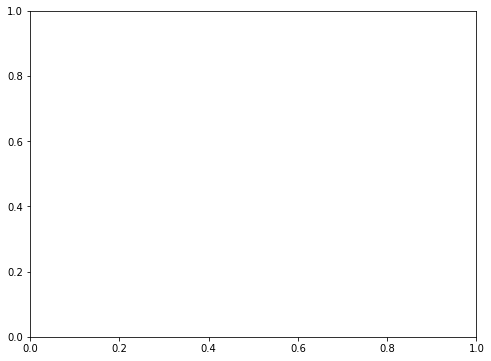

In [94]:
var, U = np.linalg.eig(trace['Sigma'][0])
angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red, *_ = sns.color_palette()

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]),
            2 * np.sqrt(5.991 * var[1]),
            angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
# e.set_zorder(10);
ax.add_artist(e);

In [67]:
packed_L = pm.LKJCholeskyCov('packed_L', n=2, eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
packed_L

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

In [64]:
y = pm.Binomial.dist(n=10, p=0.5)
y.random(size=10)

In [46]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:06<00:00, 969.72draws/s] 
The acceptance probability does not match the target. It is 0.7125111347442944, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/yuho.kida/python_DS/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1248d0cc0>,
      dtype=object)

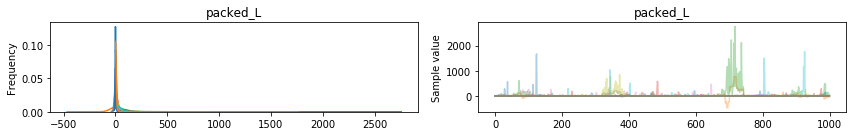

In [49]:
pm.traceplot(trace)

In [50]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
packed_L__0,13.067713,71.215299,2.170826,0.006382,39.890027,1041.762261,1.000859
packed_L__1,5.060545,50.248260,2.511354,-21.907361,52.461619,199.121393,1.006120
packed_L__2,20.715505,110.236989,7.269856,0.169858,65.448187,124.125533,1.020821


In [47]:
with model:
    pm.sample_prior_predictive(samples=500)

ValueError: Cannot resolve inputs for ['packed_L']

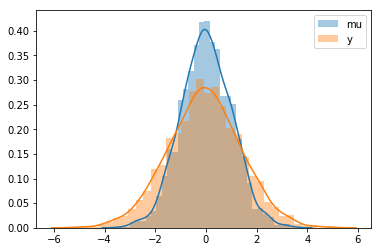